In [1]:
import warnings
warnings.filterwarnings("ignore")

from torch_geometric.nn import GCN
from torch.optim import Adam
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

from utils_data import *
from utils_classification import *
from utils_training import GraphTrainer
from utils_running import GraphRunner
from utils_evaluation import evaluate_tensor
from utils_plot import plot_confusion_matrix, plot_roc

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = "mps"

In [3]:
data = PopulationData().load_raw('data/raw/train.csv')
data.encode_connection_int()
data.encode_normalized_age()
data.encode_normalized_constitution()
data.encode_normalized_behavior()
# data.encode_standardized_age()
# data.encode_standardized_constitution()
# data.encode_standardized_behavior()
#data.encode_connection_lists()
data.encode_graph_nx()
data.encode_degree()
data.encode_degree_centrality()
data.encode_clustering_coefficient()
data.encode_normalized_degree()
# data.encode_normalized_degree_centrality()
# data.encode_normalized_clustering_coefficient()
# data.encode_standardized_degree()
# data.encode_standardized_degree_centrality()
# data.encode_standardized_clustering_coefficient()
# data.encode_connected_index_patient()
data.encode_distance_to_index_patient()
data.encode_normalized_distance_to_index_patient()
# data.encode_standardized_distance_to_index_patient()
data.encode_sum_neighbor_age()
data.encode_sum_neighbor_constitution()
data.encode_sum_neighbor_behavior()
data.encode_sum_neighbor_degree()
# data.encode_sum_neighbor_degree_centrality()
# data.encode_sum_neighbor_clustering_coefficient()
data.encode_normalized_sum_neighbor_age()
data.encode_normalized_sum_neighbor_constitution()
data.encode_normalized_sum_neighbor_behavior()
data.encode_normalized_sum_neighbor_degree()
# data.encode_normalized_sum_neighbor_degree_centrality()
# data.encode_normalized_sum_neighbor_clustering_coefficient()
# data.encode_standardized_sum_neighbor_age()
# data.encode_standardized_sum_neighbor_constitution()
# data.encode_standardized_sum_neighbor_behavior()
# data.encode_standardized_sum_neighbor_degree()
# data.encode_standardized_sum_neighbor_degree_centrality()
# data.encode_standardized_sum_neighbor_clustering_coefficient()
# data.encode_mean_neighbor_age()
# data.encode_mean_neighbor_constitution()
# data.encode_mean_neighbor_behavior()
# data.encode_mean_neighbor_degree()
# data.encode_mean_neighbor_degree_centrality()
# data.encode_mean_neighbor_clustering_coefficient()
# data.encode_normalized_mean_neighbor_age()
# data.encode_normalized_mean_neighbor_constitution()
# data.encode_normalized_mean_neighbor_behavior()
# data.encode_normalized_mean_neighbor_degree()
# data.encode_normalized_mean_neighbor_degree_centrality()
# data.encode_normalized_mean_neighbor_clustering_coefficient()
data.encode_test_train()

In [4]:
# print the data
print(data.data_df.head())

       Population  Index_Patient  Infected  Age  Constitution  Behaviour   
ID                                                                         
527649         A0              0         1   49      0.347675          2  \
461168         A0              0         1   80      0.324719          1   
371773         A0              0         1   71      0.583583          1   
79019          A0              0         1   60      0.439978          2   
197953         A0              0         1   49      0.553221          1   

                                              Connections  Normalized_Age   
ID                                                                          
527649  [461168, 371773, 79019, 226218, 24816, 307769,...        0.387097  \
461168  [527649, 197953, 634593, 239320, 202858, 60289...        0.637097   
371773  [527649, 229, 138229, 257271, 130635, 127788, ...        0.564516   
79019   [527649, 214986, 217603, 585886, 550057, 36240...        0.475806   
19795

In [5]:
features = ['Normalized_Age',
			'Normalized_Behaviour',
			'Normalized_Constitution',
			'Normalized_Degree',
			'Normalized_Distance_to_Index_Patient',
			'Normalized_Sum_Neighbor_Age',
			'Normalized_Sum_Neighbor_Behaviour',
			'Normalized_Sum_Neighbor_Constitution',
			'Normalized_Sum_Neighbor_Degree']
graph = data.get_graph_torch(features=features)

In [6]:
# Define model parameters
in_channels = len(features)  # Number of input features (Age, Constitution, Behaviour, Population)
hidden_channels = 24 # Number of hidden features
out_channels = 1  # Number of output classes (Infected/Not Infected)

In [7]:
# Initialize the model
model = GraphConvolutionalNetwork(in_channels, hidden_channels, out_channels)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [8]:
trainer = GraphTrainer(model, criterion, optimizer)
trainer.train(graph, num_epochs=100, device='cuda')

100%|██████████| 100/100 [00:03<00:00, 31.18it/s]

Best model found at epoch 99 with evaluation loss: 0.6745


In [9]:
trainer.test(graph, device='cuda')

Test loss: 0.6823


In [11]:
runner = GraphRunner(model)
test_probabilities = runner.predict_proba(graph, device=device)
test_predictions = runner.predict(graph, device=device)

# Apply the test mask
test_predictions = test_predictions[graph.test_mask]
test_probabilities = test_probabilities[graph.test_mask]
test_labels = graph.y[graph.test_mask].to(device).float()

In [12]:
print("Test Predictions:", test_predictions)
print("Test Probabilities:", test_probabilities)
print("Average Probability:", torch.mean(test_probabilities))
print("Shape of test_probabilities:", test_probabilities.shape)
print("Test Labels:", test_labels)

Test Predictions: tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
Test Probabilities: tensor([0.6106, 0.5434, 0.4697,  ..., 0.5232, 0.4952, 0.4504], device='cuda:0')
Average Probability: tensor(0.4684, device='cuda:0')
Shape of test_probabilities: torch.Size([97500])
Test Labels: tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')


In [14]:
accuracy, precision, recall, f1, auc_roc, confusion_matrix = evaluate_tensor(test_predictions, test_probabilities, test_labels, device=device)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Accuracy: 0.5600
Precision: 0.5512
Recall: 0.3449
F1: 0.4243
AUC-ROC: 0.5761


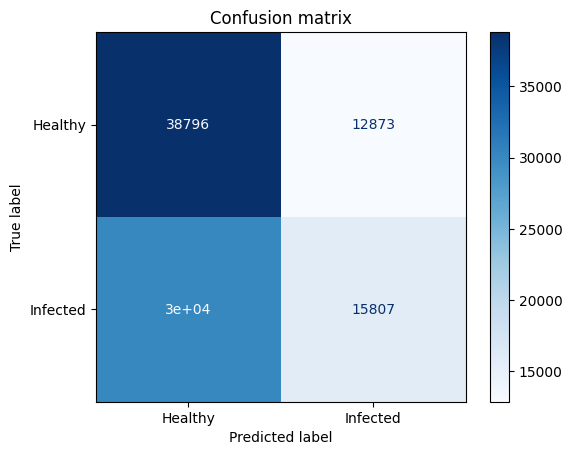

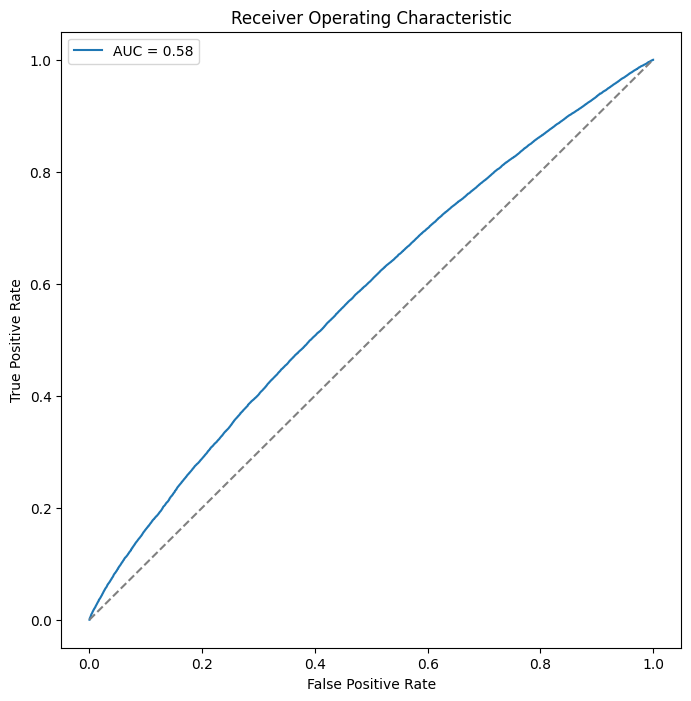

In [15]:
plot_confusion_matrix(confusion_matrix, ['Healthy', 'Infected'])
plot_roc(test_probabilities.cpu().numpy(), graph.y[graph.test_mask].cpu().numpy())